## Model Woody Cover Fraction (WCF)

Steps are:
- Import training data
- Train the model
- Save out model as a pickle

#### Import modules

In [16]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
# from datacube.helpers import write_geotiff
from dea_tools.datahandling import load_ard
from dea_tools.datahandling import mostcommon_crs
from dea_tools.plotting import display_map
from dea_tools.plotting import rgb
from dea_tools.classification import predict_xr
from dea_tools.classification import sklearn_unflatten
from dea_tools.classification import sklearn_flatten
# from datacube_stats.statistics import GeoMedian

import sklearn
print(sklearn.__version__)

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import numpy as np
import xarray as xr
from sklearn.model_selection import GridSearchCV
import pickle

1.3.2


In [17]:
dc = datacube.Datacube(app='Alberts Forest')

#### Import training data csv

In [19]:
path = './WCF_traindata_14122019.csv'
df = pd.read_csv(path)
df.head()

WCF      blue     green       red      nir    swir1     swir2
0  0.680150  0.024840  0.038088  0.041936  0.20717  0.11010  0.062355
1  0.408790  0.043154  0.063489  0.069489  0.22708  0.17888  0.115670
2  0.000004  0.034636  0.064774  0.063311  0.32425  0.21022  0.111040
3  0.216960  0.032932  0.046541  0.050958  0.18029  0.17601  0.108140
4  0.434480  0.030078  0.046560  0.047636  0.20356  0.12678  0.073669

Inspect data

(array([3.6500e+02, 3.5900e+03, 1.0193e+04, 4.4710e+03, 3.0120e+03,
        3.2690e+03, 2.4770e+03, 2.5370e+03, 2.2850e+03, 2.1010e+03,
        1.8160e+03, 1.5520e+03, 1.5340e+03, 8.4900e+02, 3.1400e+02,
        1.2200e+02, 9.6000e+01, 7.7000e+01, 4.9000e+01, 5.5000e+01,
        4.0000e+01, 2.9000e+01, 3.3000e+01, 1.8000e+01, 1.2000e+01,
        1.9000e+01, 1.1000e+01, 3.0000e+00, 6.0000e+00, 3.0000e+00]),
 array([-0.00074808,  0.01537486,  0.03149779,  0.04762073,  0.06374366,
         0.0798666 ,  0.09598954,  0.11211247,  0.12823541,  0.14435834,
         0.16048128,  0.17660422,  0.19272715,  0.20885009,  0.22497302,
         0.24109596,  0.2572189 ,  0.27334183,  0.28946477,  0.3055877 ,
         0.32171064,  0.33783358,  0.35395651,  0.37007945,  0.38620238,
         0.40232532,  0.41844826,  0.43457119,  0.45069413,  0.46681706,
         0.48294   ]),
 <BarContainer object of 30 artists>)

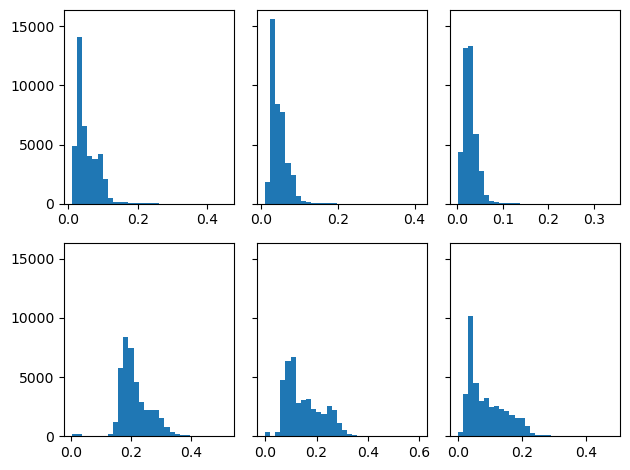

In [20]:
# Plot training data bands
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
axs[0,0].hist(df[' red'],bins=30)
axs[0,1].hist(df[' green'],bins=30)
axs[0,2].hist(df['blue'],bins=30)
axs[1,0].hist(df[' nir'],bins=30)
axs[1,1].hist(df[' swir1'],bins=30)
axs[1,2].hist(df[' swir2'],bins=30)

<Axes: >

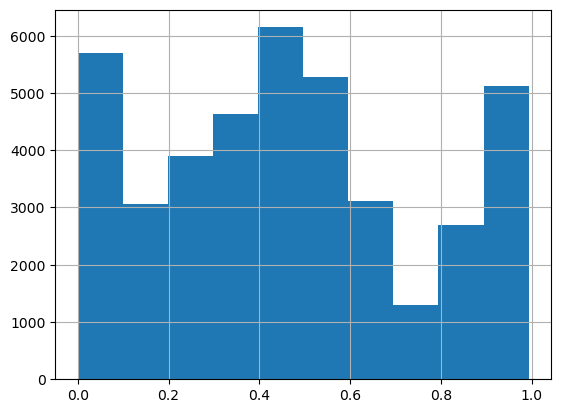

In [21]:
# Plot a histogram of WCF values
df['WCF'].hist()

#### Create and evaluate model

Format training data

In [22]:
# Handle misisng data
df = df.dropna()

# Define dependent variable
Y = df['WCF']

# Define independent variables
X = df.drop(labels=['WCF'],axis=1)

# Split model into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

Make the model

In [25]:
# Define model
model = RandomForestRegressor(n_estimators=100,
                              criterion = 'squared_error', # was 'mse' in sklearn 1.0
                              min_samples_split = 2, 
                              min_samples_leaf = 50,
                              min_weight_fraction_leaf = 0,
                              max_features = None, # was 'auto' in sklearn 1.0
                              min_impurity_decrease = 0,
                              bootstrap = True,
                              oob_score = False,
                              random_state=20,
                              verbose = 0,
                              warm_start = False
                             )

# Fit model
model.fit(X_train,Y_train)

# Predict test data
prediction_test = model.predict(X_test)

### Check performance metrics

In [26]:
# Metrics
print('Explained variance score = ')
print(metrics.explained_variance_score(Y_test, prediction_test)) # what measure to use https://scikit-learn.org/stable/modules/model_evaluation.html
print('R^2 =')
print(metrics.r2_score(Y_test, prediction_test))
print('RMSE =')
print(metrics.mean_squared_error(Y_test, prediction_test))

Explained variance score = 
0.9248337216856256
R^2 =
0.924811613952394
RMSE =
0.006270028023373599


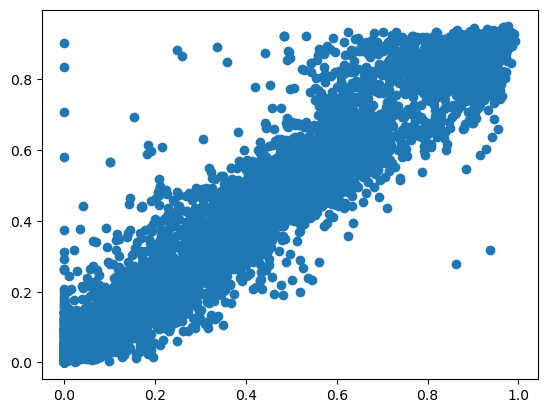

In [27]:
# Plot predicted vs test data
plt.scatter(Y_test, prediction_test)

Determine order of importance

In [28]:
# Determine the importance of each of the bands
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)

 swir1    0.634060
 nir      0.154891
 green    0.091762
 swir2    0.085120
blue      0.021067
 red      0.013102
dtype: float64


#### Pickle the model for future use

In [29]:
# Pickle this model
pickle_out = open('wcf_pickle_sklearn_version_1-3-2.pickle','wb')
pickle.dump(model,pickle_out)
pickle_out.close()